In [1]:
import numpy as np
from scipy.stats import beta, truncnorm
from tqdm import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline

In [2]:
# simulate true aneuploidy rate
n_i = 1000
def mukappa_to_alphabeta(mu, kappa):
    # Calculate alpha and beta
    alpha = mu * kappa
    beta = (1.0 - mu) * kappa
    return alpha, beta
    
# Draw from the true aneuploidy distribution ... 
mu_a = 0.5
sigma_a = 0.1
kappa_a = (mu_a *(1-mu_a))/(sigma_a**2) - 1
a, b = mukappa_to_alphabeta(mu_a, kappa_a)

CPU times: user 1.24 s, sys: 14.7 ms, total: 1.26 s
Wall time: 1.29 s
CPU times: user 1.72 ms, sys: 207 µs, total: 1.93 ms
Wall time: 2.35 ms


Text(0, 0.5, 'Density')

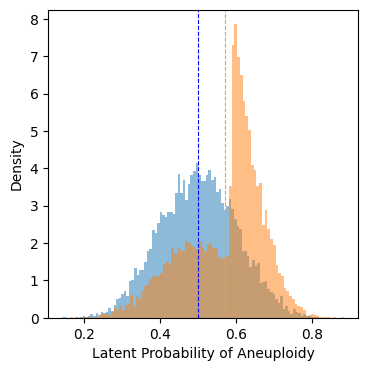

In [3]:
def draw_ascertained_rates(a, b, alpha=0.5, q_value=0.80, size=100, seed=10):
    """Draw some of the ascertained."""
    assert seed > 0
    assert (alpha >= 0.0) & (alpha <= 1.0)
    np.random.seed(seed)
    samp = np.zeros(size)
    for i in range(size):
        if np.random.uniform() <= alpha:
            found = False
            while not found:
                x = beta.rvs(a,b, size=100)
                x1 = x[x >= beta.ppf(q_value, a,b)]
                if x1.size > 0:
                    samp[i] = x1[0]
                    found = True
        else:
            samp[i] = beta.rvs(a,b)
    return samp

%time asc_vals = draw_ascertained_rates(a=a, b=b, size=10000, alpha=0.5, q_value=0.8)
%time true_vals = beta.rvs(a, b, size=10000)
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.hist(true_vals, bins=100, density=True, alpha=0.5);
ax.hist(asc_vals, bins=100, density=True, alpha=0.5);

ax.axvline(np.mean(asc_vals), color='orange', lw=0.8, linestyle='--')
ax.axvline(np.mean(true_vals), color='blue', lw=0.8, linestyle='--')
ax.set_xlabel('Latent Probability of Aneuploidy')
ax.set_ylabel('Density')

7it [00:11,  1.60s/it]


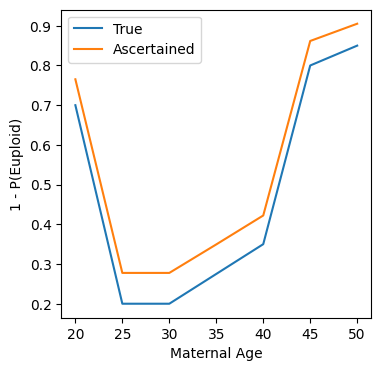

In [4]:
# Now look at how this might look like under different degress of ascertainment
# We can kind of fit these from the Gruhn et al 2019 paper...
mat_ages = np.array([20, 25, 30, 35, 40, 45, 50])
mu_a = np.array([0.7, 0.2, 0.2, 0.275, 0.35, 0.8, 0.85])
sigma_a = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
kappa_a = (mu_a *(1-mu_a))/(sigma_a**2) - 1

# now we setup the ascertained values ... 
asc_mu = np.zeros(mat_ages.size)
for i, (m,k) in tqdm(enumerate(zip(mu_a, kappa_a))):
    a,b = mukappa_to_alphabeta(m,k)
    asc_vals = draw_ascertained_rates(a=a, b=b, size=10000, alpha=0.5, q_value=0.8)
    asc_mu[i] = np.mean(asc_vals)


fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(mat_ages, mu_a, label=r'True')
ax.plot(mat_ages, asc_mu, label=r'Ascertained')
ax.set_ylabel(r'1 - P(Euploid)')
ax.set_xlabel(r'Maternal Age')
ax.legend()

(0.0, 1.0)

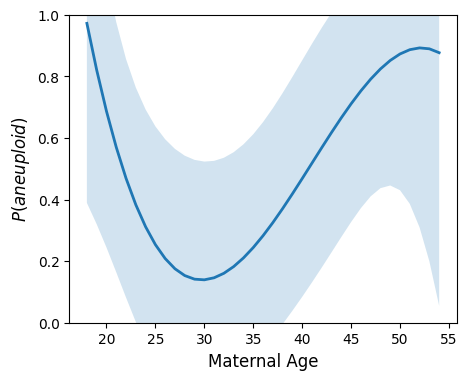

In [5]:
xs = np.arange(18, 55)
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(xs.reshape(-1,1))

xp_gruhn = polynomial_features.fit_transform(mat_ages.reshape(-1,1))
model_gruhn = sm.OLS(mu_a, xp_gruhn).fit()
ypred_gruhn = model_gruhn.predict(xp)
_, upper_gruhn, lower_gruhn = wls_prediction_std(model_gruhn, xp)

fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(xs, ypred_gruhn, lw=2)
ax.fill_between(xs, upper_gruhn, lower_gruhn, alpha=0.2)
ax.set_xlabel('Maternal Age', fontsize=12)
ax.set_ylabel(r'$P(aneuploid)$', fontsize=12)
ax.set_ylim(0, 1.0)